# Imports

In [1]:
import pandas as pd
import numpy as np
from recommender import load_raw_data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Loading & Inspecting Data

In [2]:
# load
original_df = load_raw_data()

[INFO] CSV already exists at c:\Users\asads\Documents\CS506_FinalProject\new-game-plus-backend\newgameplus\data\games.csv


In [3]:
# copy 
df = original_df.copy()

In [4]:
# get first 5
pd.set_option('display.max_columns', None)
print("df.head()=================================================")
print(df.head())

# get data structure
print("df.dtypes=================================================")
print(df.dtypes)

# get num of nulls
print("df.isnul().sum()=================================================")
print(df.isnull().sum())

# get num of uniques
print("df.nunique()=================================================")
print(df.nunique())

df.head()=================================================
    appid                             name release_date  required_age  price  \
0     730                 Counter-Strike 2   2012-08-21             0   0.00   
1  578080              PUBG: BATTLEGROUNDS   2017-12-21             0   0.00   
2     570                           Dota 2   2013-07-09             0   0.00   
3  271590        Grand Theft Auto V Legacy   2015-04-13            17   0.00   
4  488824  Tom Clancy's Rainbow Six® Siege   2015-12-01            17  19.99   

   dlc_count                               detailed_description  \
0          1  For over two decades, Counter-Strike has offer...   
1          0  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2          2  The most-played game on Steam. Every day, mill...   
3          0  When a young street hustler, a retired bank ro...   
4          9  Edition Comparison Ultimate Edition The Tom Cl...   

                                      about_the_game  \
0

# Preprocessing

In [5]:
# store the metadata for the recommender
df_metadata = df[['appid', 'name', 'price', 'header_image', 'short_description', 'detailed_description', 'website']].copy()

# remove the null name rows
df = df.drop(df.loc[df['name'].isna()].index)

# drop USELESS columns
df = df.drop(['name', 'tags','reviews', 'detailed_description', 'about_the_game', 'short_description', 'header_image', 'website', 'support_url','support_email','metacritic_url','notes', 'packages', 'developers', 'publishers','screenshots', 'movies','user_score','score_rank','estimated_owners','positive','negative'], axis=1) # edw: undrop reviews and sentiment thing

In [6]:
# clean data
df['release_date_cleaned'] = pd.to_datetime(df['release_date'], errors='coerce')
df = df.drop(['release_date'], axis=1)

In [7]:
#Idetnfying the unique supported_languages


#print(type(df['supported_languages'].iloc[0]))

#def clean_language(lang):
    # Remove leading/trailing whitespace and newlines
#    lang = lang.strip()
    # Remove HTML-like tags (like [b][/b])
#    lang = re.sub(r'\[/?b\]', '', lang)
    # Strip again after removing tags
#    lang = lang.strip()
#    return lang


#df['supported_languages'] = df['supported_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 

#unique_supported_languages = set()

#for langs in df['supported_languages']:  # Replace with your actual column name
#    if isinstance(langs, list):
#        for lang in langs:
            # Some entries may still have multiple langs joined with commas
#            for l in lang.split(','):
#                cleaned = clean_language(l)
#                unique_supported_languages.add(cleaned)

#unique_supported_languages = list(unique_supported_languages)
#print("Unique supported languages", unique_supported_languages)


In [8]:
#One hot encoding the languages

#lang_columns = {}

#for lang in unique_supported_languages:
#    lang_columns[lang+"_supported_languages"] = df['supported_languages'].apply(lambda x: 1 if lang in x else 0)

#lang_df = pd.DataFrame(lang_columns)

#df = pd.concat([df, lang_df], axis=1)

df.drop("supported_languages", axis = 1, inplace = True)

#print(df.head())

In [9]:
#identify the unique supported audios
#df['full_audio_languages'] = df['full_audio_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) 

#unique_full_audio_languages = set()

#for langs in df['full_audio_languages']:  # Replace with your actual column name
#    if isinstance(langs, list):
#        for lang in langs:
            # Some entries may still have multiple langs joined with commas
#            for l in lang.split(','):
#                cleaned = clean_language(l)
#                unique_full_audio_languages.add(cleaned)

#unique_full_audio_languages = list(unique_full_audio_languages)
#print("Unique Full Audio Languages:", unique_full_audio_languages)

In [10]:
#one hot encoding full audio languages

#audio_lang_columns = {}

#for audio_lang in unique_full_audio_languages:
#    audio_lang_columns[audio_lang+"_full_audio_languages"] = df['full_audio_languages'].apply(lambda x: 1 if lang in x else 0)

#audio_lang_df = pd.DataFrame(audio_lang_columns)

#df = pd.concat([df, audio_lang_df], axis=1)

df.drop("full_audio_languages", axis=1, inplace=True)


#print(df.head())

In [11]:
#Identifying the unique genres
import ast
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

unique_genres = set()

for genres in df['genres']:
    if isinstance(genres, list):
        unique_genres.update(genres)

unique_genre_list = list(unique_genres)
#print("Unique genres:", unique_genre_list)

In [12]:
#One hot encoding the genres
for genre in unique_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)

df.drop("genres", axis=1, inplace=True)


#print(df.head())

In [13]:
#identifying unique categories

import ast
df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

unique_categories = set()

for categories in df['categories']:
    if isinstance(categories, list):
        unique_categories.update(categories)

unique_categories_list = list(unique_categories)
#print("Unique categories:", unique_categories_list)

In [14]:
#One hot encoding the genres

for categories in unique_categories:
    df[categories] = df['categories'].apply(lambda x: 1 if categories in x else 0)

df.drop("categories", axis=1, inplace=True)

#print(df.head())

In [15]:
# convert boolean into numerical
df['windows'] = df['windows'].astype(int)
df['mac'] = df['mac'].astype(int)
df['linux'] = df['linux'].astype(int)


In [16]:
# drop datetime
df = df.drop('release_date_cleaned', axis=1)

In [17]:
# get remaining columns
remaining_columns = [col for col in df.columns if col not in unique_genre_list + unique_categories_list]
# drop correlated features
# take out genres that highly correlate based on heatmap
genres_to_remove = ['Gore', 'Tutorial', 'Movie', 'Animation & Modeling', 'Short', '360 Video', 'Documentary', 'Sexual Content']
unique_genre_list = [genre for genre in unique_genre_list if genre not in genres_to_remove]

In [18]:
# take out categories that highly correlate based on heatmap
categories_to_remove = ['Shared/Split Screen PvP', 'Remote Play on Tablet', 'Multi-player', 'Remote Play Together', 'Tracked Controller Support', 'Shared/Split Screen', "Online PvP", "Co-op", 'Family Sharing', 'Includes level editor', 'Steam Cloud']
unique_categories_list = [category for category in unique_categories_list if category not in categories_to_remove]

In [19]:
# take out categories that highly correlate based on heatmap
remaining_to_remove = ['mac','recommendations', 'num_reviews_total', 'average_playtime_2weeks', 'median_playtime_forever', 'median_playtime_2weeks', 'pct_pos_recent', 'peak_ccu']
remaining_columns = [remaining for remaining in remaining_columns if remaining not in remaining_to_remove]

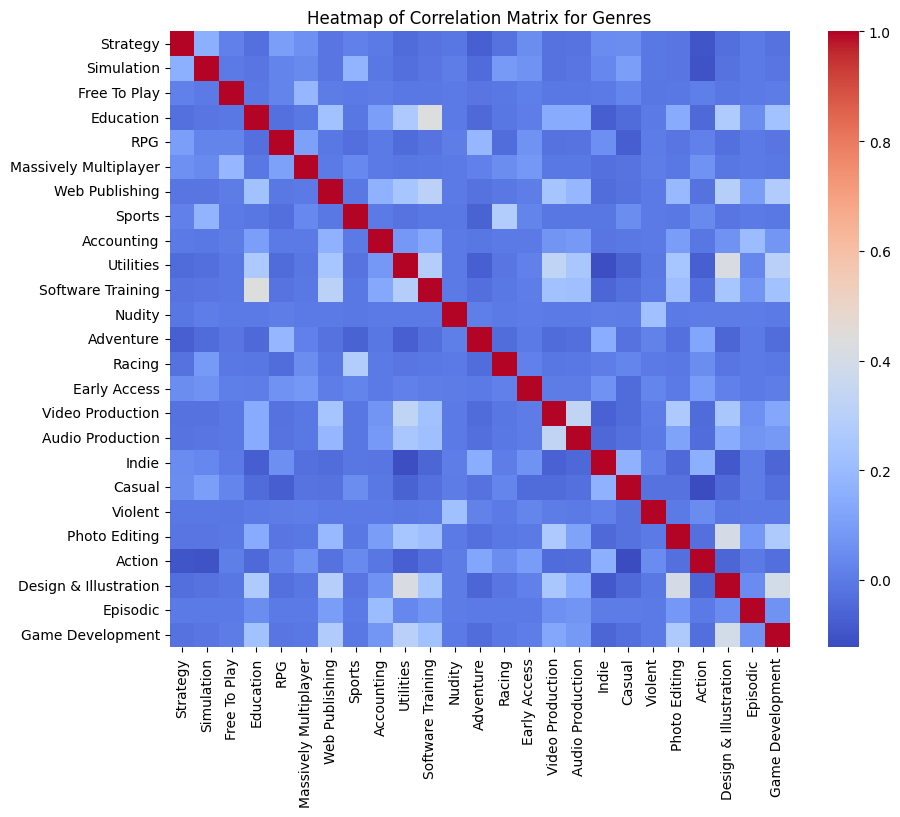

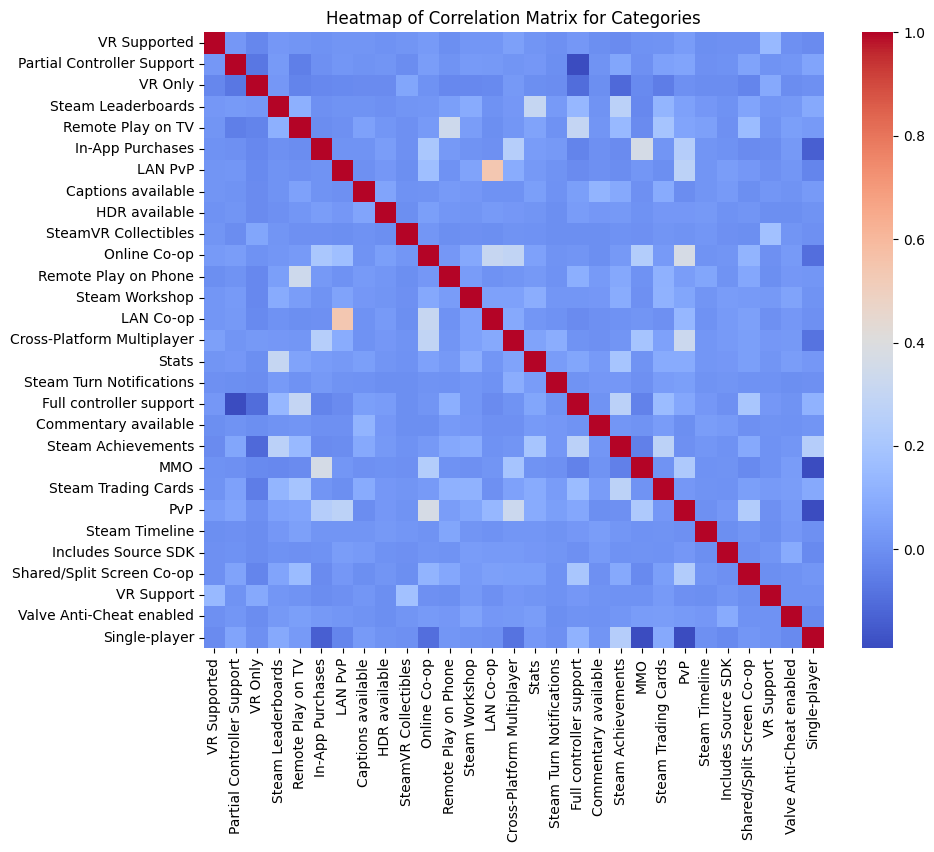

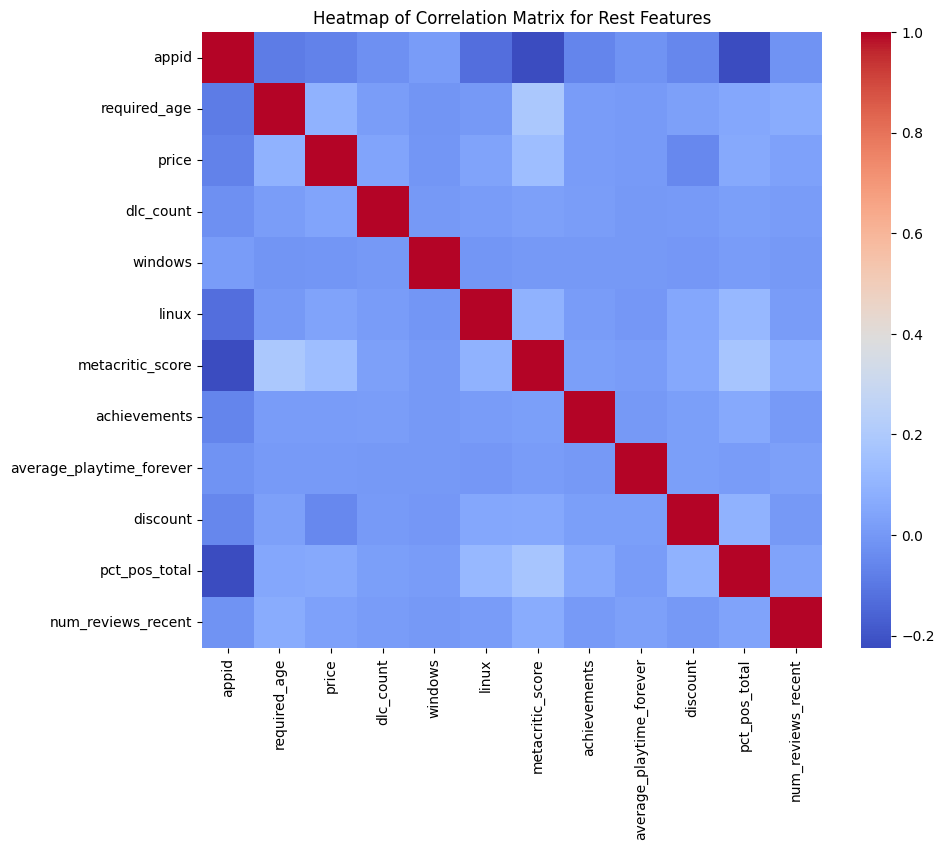

In [20]:
# heatmap correlation for genres
# we can find out what genres to drop (the dependent ones)
X = df[unique_genre_list].copy()

plt.figure(figsize=(10, 8))  
sns.heatmap(X.corr(), cmap="coolwarm")  
plt.title("Heatmap of Correlation Matrix for Genres")  
plt.show()

# heatmap correlation for categories
X = df[unique_categories_list].copy()
plt.figure(figsize=(10, 8))  
sns.heatmap(X.corr(), cmap="coolwarm")  
plt.title("Heatmap of Correlation Matrix for Categories")  
plt.show()

# heatmap correlation for categories
X = df[remaining_columns].copy()
plt.figure(figsize=(10, 8))  
sns.heatmap(X.corr(), cmap="coolwarm")  
plt.title("Heatmap of Correlation Matrix for Rest Features")  
plt.show()

# TODO: merge similar features based on this

In [21]:
pd.set_option('display.max_columns', None)
# combine all column lists
all_columns = unique_genre_list + unique_categories_list + remaining_columns

# filter the DataFrame for those columns
X = df[all_columns].copy()
X

,Strategy,Simulation,Free To Play,Education,RPG,Massively Multiplayer,Web Publishing,Sports,Accounting,Utilities,Software Training,Nudity,Adventure,Racing,Early Access,Video Production,Audio Production,Indie,Casual,Violent,Photo Editing,Action,Design & Illustration,Episodic,Game Development,VR Supported,Partial Controller Support,VR Only,Steam Leaderboards,Remote Play on TV,In-App Purchases,LAN PvP,Captions available,HDR available,SteamVR Collectibles,Online Co-op,Remote Play on Phone,Steam Workshop,LAN Co-op,Cross-Platform Multiplayer,Stats,Steam Turn Notifications,Full controller support,Commentary available,Steam Achievements,MMO,Steam Trading Cards,PvP,Steam Timeline,Includes Source SDK,Shared/Split Screen Co-op,VR Support,Valve Anti-Cheat enabled,Single-player,appid,required_age,price,dlc_count,windows,linux,metacritic_score,achievements,average_playtime_forever,discount,pct_pos_total,num_reviews_recent
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,730,0,0.00,1,1,1,0,1,33189,0,86,96473
1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,578080,0,0.00,0,1,0,0,37,0,0,59,16720
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,570,0,0.00,2,1,1,90,0,43031,0,81,29366
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,271590,17,0.00,0,1,0,96,77,19323,0,87,17517
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,488824,17,19.99,9,1,0,0,0,0,0,84,13017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94943,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,2115110,0,3.99,0,1,0,0,6,0,0,-1,-1
94944,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1174200,0,10.00,0,1,0,0,0,0,0,-1,-1
94945,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1160190,0,1.99,0,1,0,0,0,0,0,-1,-1
94946,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,3380340,0,29.99,0,1,0,0,34,0,0,-1,-1


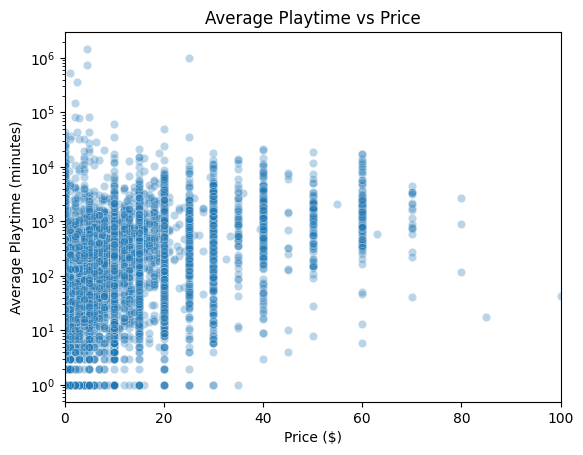

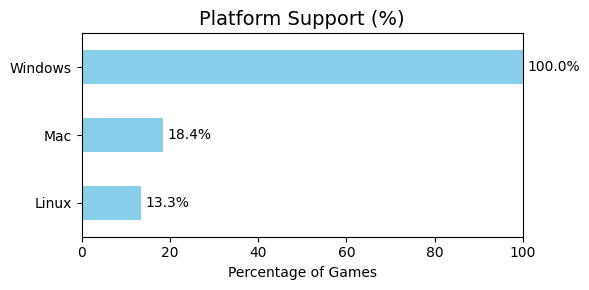

In [22]:
# Plot of price vs average playtime
sns.scatterplot(data=df, x='price', y='average_playtime_forever', alpha=0.3)
plt.xlim(0, 100)
plt.yscale('log')
plt.title('Average Playtime vs Price')
plt.xlabel('Price ($)')
plt.ylabel('Average Playtime (minutes)')
plt.show()

# Plot of percentage of games supported on each platform
platform_support = df[['windows', 'mac', 'linux']].mean().rename({
    'windows': 'Windows',
    'mac': 'Mac',
    'linux': 'Linux'
}) * 100

plt.figure(figsize=(6, 3))
platform_support.sort_values().plot(kind='barh', color='skyblue')

for i, (value, label) in enumerate(zip(platform_support.sort_values(), platform_support.sort_values().index)):
    plt.text(value + 1, i, f'{value:.1f}%', va='center', fontsize=10)

plt.title('Platform Support (%)', fontsize=14)
plt.xlabel('Percentage of Games')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()



# MODELING

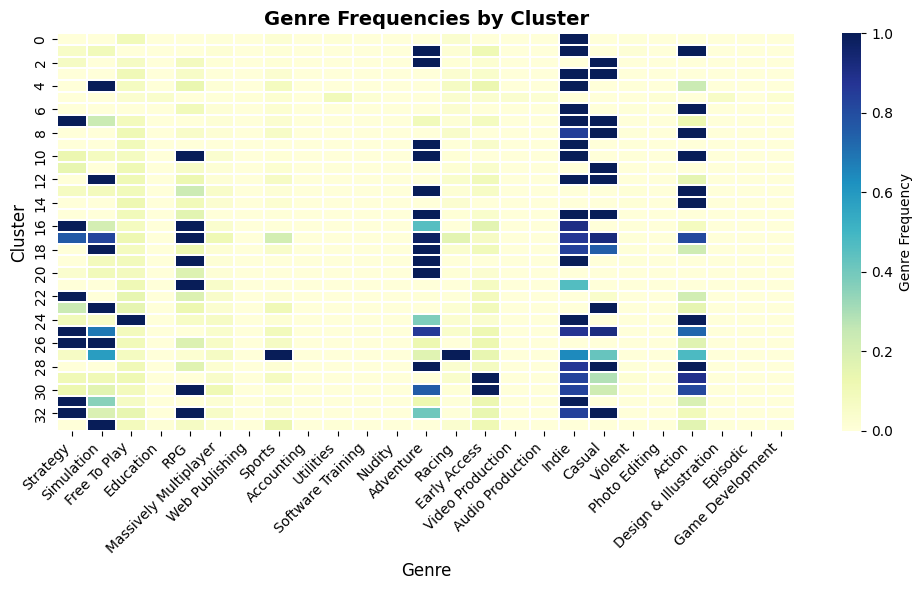

Number of games per genre cluster:
genre_cluster
0     2988
1     5640
2     1692
3     6745
4     1875
5     7285
6     5661
7     3865
8     4394
9     4060
10    1746
11    3901
12    3053
13    2481
14    3141
15    4094
16    1541
17    1244
18    2534
19    1541
20    2677
21    2059
22    2125
23    1387
24    1147
25    1359
26     969
27     903
28    3004
29    2386
30    1441
31    3325
32     807
33    1876
Name: count, dtype: int64


In [23]:
# Scale the data
scaler = StandardScaler()
X = df[unique_genre_list].copy()

# Use KMeans to cluster the genres, run many times to get the best result
kmeans = KMeans(n_clusters=34, init='k-means++', n_init=250, random_state=97)
cluster_labels = kmeans.fit_predict(X)

# Assign cluster labels to dataframe
df['genre_cluster'] = cluster_labels

# Elbow method to find the optimal number of clusters
# inertia_vals = []
# k_values = range(2, 20)

# for k in k_values:
#     km = KMeans(n_clusters=k, init='k-means++')
#     km.fit(X)
#     inertia_vals.append(km.inertia_)

# plt.figure()
# plt.plot(k_values, inertia_vals, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Genre Clustering')
# plt.tight_layout()
# plt.show()

# Heatmap of genre frequencies by cluster
df_genres = df[unique_genre_list + ['genre_cluster']]
cluster_genre_means = df_genres.groupby('genre_cluster')[unique_genre_list].mean()

plt.figure(figsize=(len(unique_genre_list) * 0.4, 6))
sns.heatmap(cluster_genre_means,
            cmap='YlGnBu',
            linewidths=0.3,
            cbar_kws={'label': 'Genre Frequency'})

plt.title("Genre Frequencies by Cluster", fontsize=14, weight='bold')
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the number of games in each cluster
cluster_counts = df['genre_cluster'].value_counts().sort_index()
print("Number of games per genre cluster:")
print(cluster_counts)

In [24]:
# # find how well the clustering went
# score = silhouette_score(X, cluster_labels)
# print(score)

C:\Users\asads\AppData\Local\Temp\ipykernel_37104\2353188628.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='price_cluster', y='price', data=df, palette='Set2')


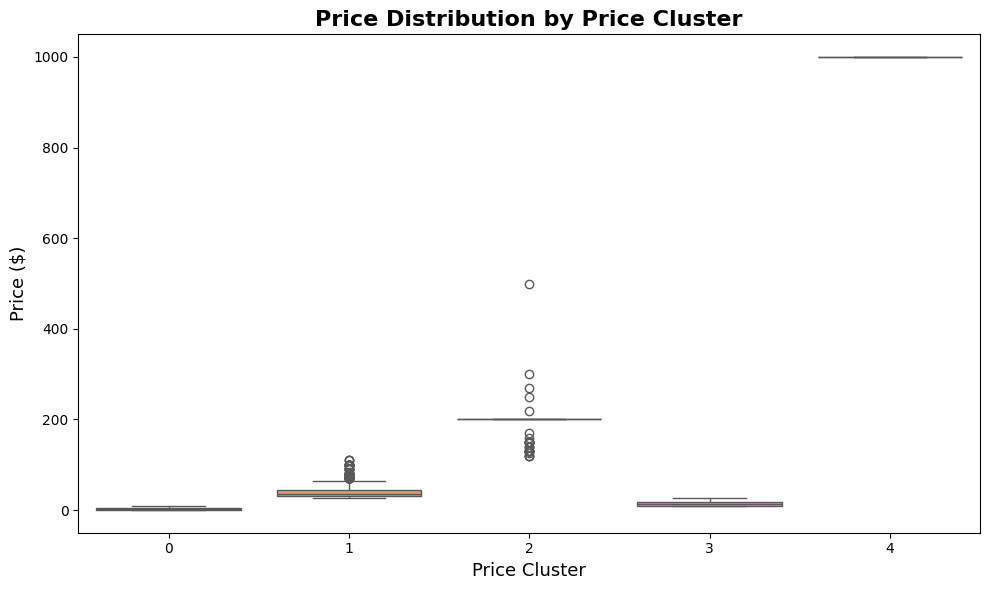

Number of games per price cluster:
price_cluster
0    68174
1     2721
2      178
3    23870
4        3
Name: count, dtype: int64


In [25]:
# Create a copy of the dataframe for price clustering
X_price = df[['price']].copy()

# Scale the data
scaler = StandardScaler()
X_price_scaled = scaler.fit_transform(X_price)

# Use KMeans to cluster the price, run many times to get the best result
kmeans_price = KMeans(n_clusters=5, init='k-means++', n_init=250, random_state=97)
price_cluster_labels = kmeans_price.fit_predict(X_price_scaled)

# Assign cluster labels to dataframe
df['price_cluster'] = price_cluster_labels

# Elbow method to find the optimal number of clusters
# inertia_vals_price = []
# k_values = range(2, 100)

# for k in k_values:
#     km = KMeans(n_clusters=k, init='k-means++')
#     km.fit(X_price_scaled)
#     inertia_vals_price.append(km.inertia_)

# plt.figure()
# plt.plot(k_values, inertia_vals_price, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Price Clustering')
# plt.tight_layout()
# plt.show()

# Boxplot of price distribution by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='price_cluster', y='price', data=df, palette='Set2')
plt.title("Price Distribution by Price Cluster", fontsize=16, weight='bold')
plt.xlabel("Price Cluster", fontsize=13)
plt.ylabel("Price ($)", fontsize=13)
plt.tight_layout()
plt.show()

# Print the number of games in each price cluster
price_cluster_counts = df['price_cluster'].value_counts().sort_index()
print("Number of games per price cluster:")
print(price_cluster_counts)


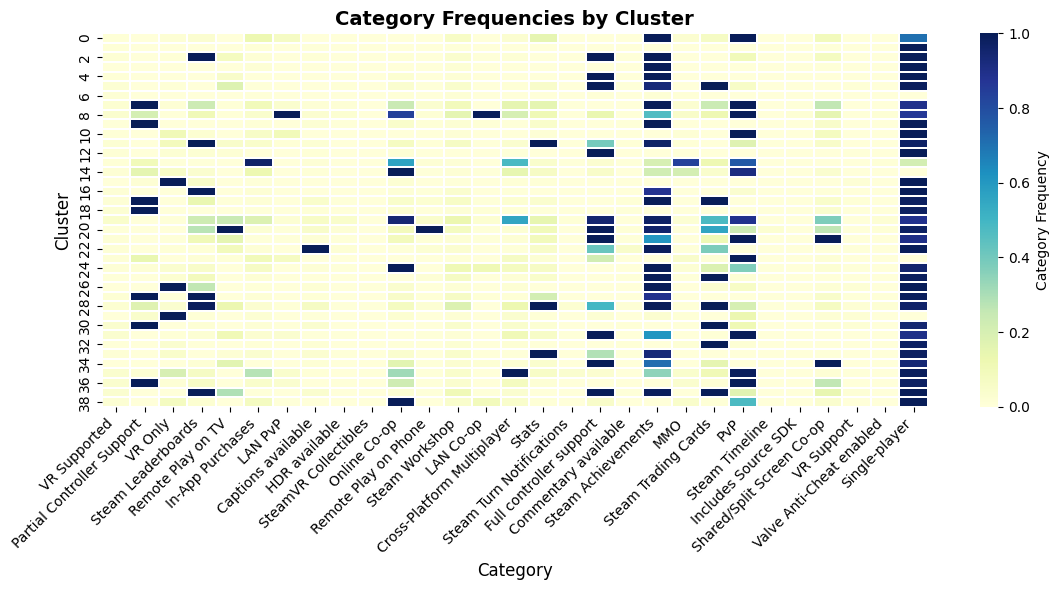

Number of games per category cluster:
categories_cluster
0       644
1     25812
2      1185
3     13679
4      6281
5      2219
6      6573
7       810
8       443
9      3411
10     1157
11     1047
12     4068
13      745
14      609
15     3088
16     1759
17     1216
18     3744
19      518
20      445
21      737
22      749
23     1181
24      659
25     2811
26      772
27      710
28      504
29      491
30      269
31      859
32     1087
33      973
34      872
35      688
36      593
37      696
38      842
Name: count, dtype: int64


In [26]:
# Create a copy of the dataframe for categories
X_categories= df[unique_categories_list].copy()

kmeans = KMeans(n_clusters=39, init='k-means++', n_init=250, random_state=97)
cluster_labels = kmeans.fit_predict(X_categories)

df['categories_cluster'] = cluster_labels

df_categories = df[unique_categories_list + ['categories_cluster']]
cluster_category_means = df_categories.groupby('categories_cluster')[unique_categories_list].mean()

plt.figure(figsize=(len(unique_categories_list) * 0.4, 6))
sns.heatmap(cluster_category_means,
            cmap='YlGnBu',
            linewidths=0.3,
            cbar_kws={'label': 'Category Frequency'})

plt.title("Category Frequencies by Cluster", fontsize=14, weight='bold')
plt.xlabel("Category", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the number of games in each cluster
categories_cluster_counts = df['categories_cluster'].value_counts().sort_index()
print("Number of games per category cluster:")
print(categories_cluster_counts)


In [27]:
# # silhoutte score for 
# score = silhouette_score(X_categories, cluster_labels)
# print(score)

C:\Users\asads\AppData\Local\Temp\ipykernel_37104\1453919529.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ccu_cluster', y='peak_ccu', data=df, palette='Set2')


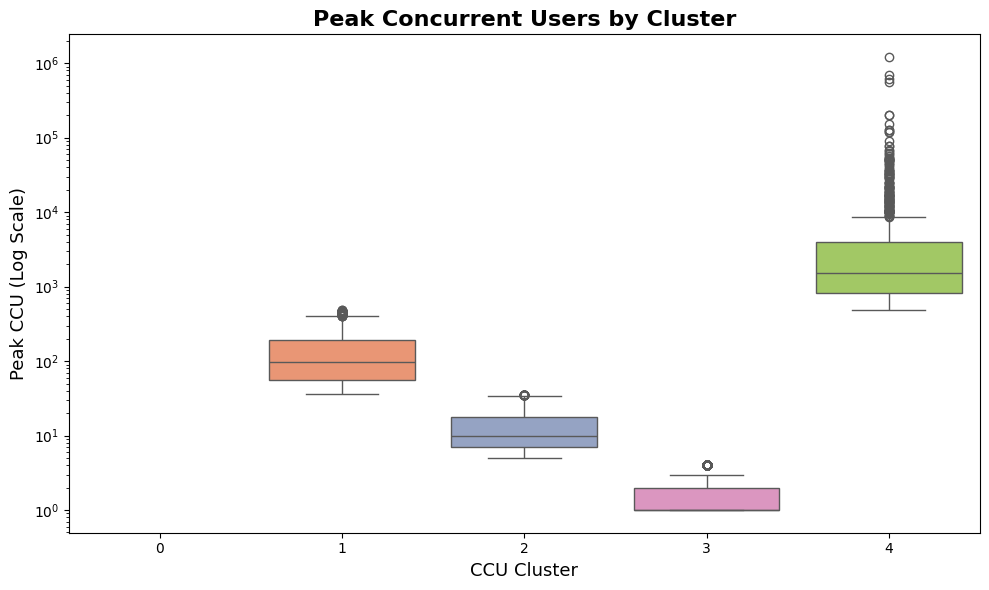

Number of games per CCU cluster:
ccu_cluster
0    76006
1     2456
2     4761
3    10869
4      854
Name: count, dtype: int64


In [28]:
# Create a copy of the dataframe for CCU clustering
df['peak_ccu_log'] = np.log1p(df['peak_ccu'])  # log1p handles 0 values safely
X_ccu_log = df[['peak_ccu_log']].copy()

# Scale the data
scaler = StandardScaler()
X_ccu_log_scaled = scaler.fit_transform(X_ccu_log)

# Use KMeans to cluster the log peak CCU, run many times to get the best result
kmeans_ccu = KMeans(n_clusters=5, init='k-means++', n_init=250, random_state=97)
ccu_cluster_labels = kmeans_ccu.fit_predict(X_ccu_log_scaled)

# Assign cluster labels to dataframe
df['ccu_cluster'] = ccu_cluster_labels

# Elbow method to find the optimal number of clusters
# inertia_vals_ccu = []
# k_values = range(2, 30)

# for k in k_values:
#     km = KMeans(n_clusters=k, init='k-means++')
#     km.fit(X_ccu_log_scaled)
#     inertia_vals_ccu.append(km.inertia_)

# plt.figure()
# plt.plot(k_values, inertia_vals_ccu, marker='o', linestyle='--')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method for Log Peak CCU Clustering')
# plt.tight_layout()
# plt.show()

# Boxplot of peak CCU distribution by cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='ccu_cluster', y='peak_ccu', data=df, palette='Set2')
plt.yscale('log')  # Important: CCU still spans large values
plt.title("Peak Concurrent Users by Cluster", fontsize=16, weight='bold')
plt.xlabel("CCU Cluster", fontsize=13)
plt.ylabel("Peak CCU (Log Scale)", fontsize=13)
plt.tight_layout()
plt.show()

# Print the number of games in each CCU cluster
ccu_cluster_counts = df['ccu_cluster'].value_counts().sort_index()
print("Number of games per CCU cluster:")
print(ccu_cluster_counts)


In [29]:
# # find how well the clustering went
# score = silhouette_score(X, ccu_cluster_labels)
# print(score)

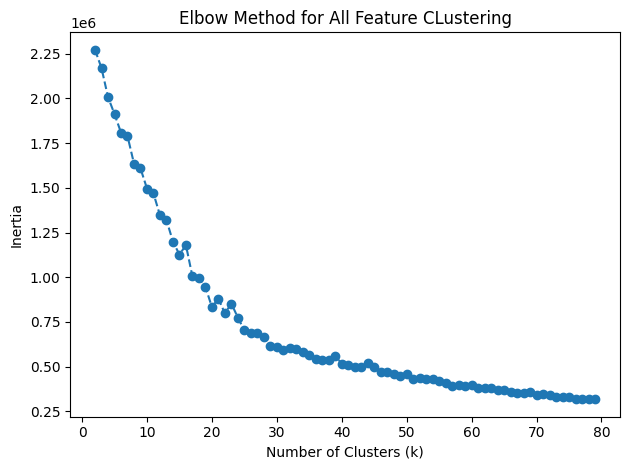

In [30]:
X_all = X

# Scale the data
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Use KMeans to cluster the price, run many times to get the best result
#kmeans_price = KMeans(n_clusters=3, init='k-means++', n_init=250, random_state=97)
#price_cluster_labels = kmeans_price.fit_predict(X_price_scaled)

# Assign cluster labels to dataframe
#df['all_cluster'] = price_cluster_labels


inertia_vals_all = []
k_values = range(2, 80)

for k in k_values:
    km = KMeans(n_clusters=k, init='k-means++')
    km.fit(X_all)
    inertia_vals_all.append(km.inertia_)

plt.figure()
plt.plot(k_values, inertia_vals_all, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for All Feature CLustering')
plt.tight_layout()
plt.show()

In [31]:
X_all = X

# Scale the data
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

# Use KMeans to cluster the price, run many times to get the best result
kmeans_all = KMeans(n_clusters=5, init='k-means++', n_init=250, random_state=97)
all_cluster_labels = kmeans_all.fit_predict(X_all_scaled)

# Assign cluster labels to dataframe
df['all_cluster'] = all_cluster_labels

score = silhouette_score(X_all, all_cluster_labels)
print(score)

0.16755821543549929


In [32]:
print(df[remaining_columns].head())

    appid  required_age  price  dlc_count  windows  linux  metacritic_score  \
0     730             0   0.00          1        1      1                 0   
1  578080             0   0.00          0        1      0                 0   
2     570             0   0.00          2        1      1                90   
3  271590            17   0.00          0        1      0                96   
4  488824            17  19.99          9        1      0                 0   

   achievements  average_playtime_forever  discount  pct_pos_total  \
0             1                     33189         0             86   
1            37                         0         0             59   
2             0                     43031         0             81   
3            77                     19323         0             87   
4             0                         0         0             84   

   num_reviews_recent  
0               96473  
1               16720  
2               29366  
3       

In [33]:
X_remaining= df[remaining_columns].copy()

kmeans = KMeans(n_clusters=18, init='k-means++', n_init=250, random_state=97)
remaining_cluster_labels = kmeans.fit_predict(X_remaining)

df['remaining_clusters'] = remaining_cluster_labels

df_remaining = df[remaining_columns + ['remaining_clusters']]
cluster_remaining_means = df_remaining.groupby('remaining_clusters')[remaining_columns].mean()

# score = silhouette_score(X_remaining, remaining_cluster_labels)
# print(score)



In [34]:
# save the clustered data
df_modeling = df.copy()
df_modeling.to_pickle("data/clustered_steam_data.pkl")

# save the frontend data
frontend_fields = ['appid', 'name', 'header_image', 'short_description', 'website']
cluster_fields = ['genre_cluster', 'categories_cluster', 'remaining_clusters']
df_metadata = original_df[frontend_fields].copy()
df_metadata = df_metadata.merge(df[['appid'] + cluster_fields], on='appid', how='left')

df_metadata.to_pickle("data/clustered_steam_metadata.pkl")

In [35]:
print(df.head())

    appid  required_age  price  dlc_count  windows  mac  linux  \
0     730             0   0.00          1        1    0      1   
1  578080             0   0.00          0        1    0      0   
2     570             0   0.00          2        1    1      1   
3  271590            17   0.00          0        1    0      0   
4  488824            17  19.99          9        1    0      0   

   metacritic_score  achievements  recommendations  average_playtime_forever  \
0                 0             1          4401572                     33189   
1                 0            37          1732007                         0   
2                90             0            14337                     43031   
3                96            77          1803063                     19323   
4                 0             0          1160724                         0   

   average_playtime_2weeks  median_playtime_forever  median_playtime_2weeks  \
0                      879                 